In [1]:
!python -m venv env

The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /content/env/bin/python3



In [2]:
!source env/bin/activate

/bin/bash: line 1: env/bin/activate: No such file or directory


In [ ]:
!pip install -r requirements.txt

In [ ]:
pip install --upgrade numpy


In [ ]:
!pip install tiktoken==0.1.2
!pip install pandas==1.5.2
!pip install openai==0.26.1
!pip install numpy==1.24.1

In [7]:
!pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 45.4 MB/s eta 0:00:00


In [15]:
import fitz as ks
print(ks.__version__)

1.23.6


In [16]:
import fitz

# Open the PDF file
pdf_file = fitz.open('/content/Meta-12.31.2022-Exhibit-99.1-FINAL.pdf')

# Extract text from all pages
extracted_text = ""
for page in pdf_file:
    text = page.get_text()
    extracted_text += text + "\n"

# Print the extracted text
#print(all_text)

# Save the extracted text to a file
with open('/content/data/output.txt', 'w') as f:
    f.write(extracted_text)


In [17]:
import numpy as np
print(np.__version__)


1.24.1


In [18]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [19]:
import pandas as pd
import os

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("/content/data/"):

    # Open the file and read the text
    with open("/content/data/" + file, "r", encoding="UTF-8",errors='ignore') as f:
        text = f.read()
        print(text)

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('/content/processed/scraped.csv')
df.head()

Meta Reports Fourth Quarter and Full Year 2022 Results
MENLO PARK, Calif. – February 1, 2023 – Meta Platforms, Inc. (Nasdaq: META) today reported financial results for the quarter 
and full year ended December 31, 2022.
"Our community continues to grow and I'm pleased with the strong engagement across our apps. Facebook just reached the 
milestone of 2 billion daily actives," said Mark Zuckerberg, Meta founder and CEO. "The progress we're making on our AI 
discovery engine and Reels are major drivers of this. Beyond this, our management theme for 2023 is the 'Year of Efficiency' and 
we're focused on becoming a stronger and more nimble organization."
Fourth Quarter and Full Year 2022 Financial Highlights
Three Months Ended December 31,
 % Change
Year Ended December 31,
% Change
In millions, except percentages and per 
share amounts
2022
2021
2022
2021
Revenue
$ 
32,165 $ 
33,671 
 (4) % $ 
116,609 $ 
117,929 
 (1) %
Costs and expenses
 
25,766  
21,086 
 22 %  
87,665  
71,176 
 23 %
I

<ipython-input-18-429202555403>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,,. Meta Reports Fourth Quarter and Full Year 20...


<Axes: >

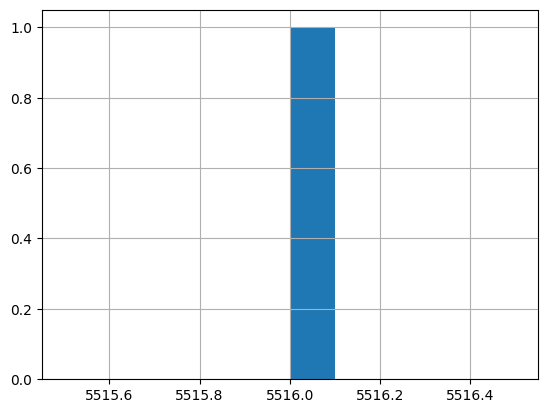

In [20]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [21]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

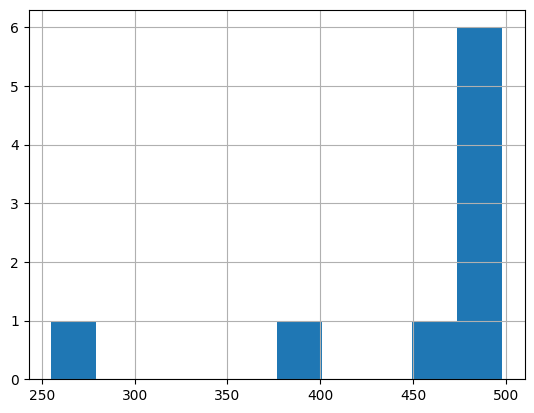

In [22]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [23]:
os.environ['OPENAI_API_KEY'] = 'sk-'#replace you OpenAi API Key here

In [24]:
import openai
openai.api_key = 'sk-'#replace you OpenAi API Key here

In [ ]:
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('/content/processed/embeddings.csv')
df.head()

In [ ]:
import numpy as np
import pandas as pd
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

In [ ]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [ ]:
def answer_question(
    df,
    model="gpt-3.5-turbo-instruct",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"Questioned cannot be answered based on context provided.\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [ ]:
answer_question(df, question="What is Revenue of meta in financial year 2021-2022?")

In [ ]:
answer_question(df, question="who is the leader of the Meta ?")

In [ ]:
answer_question(df, question="What is the context and brief it in 50 words?", debug=False)